我们将首先在 MNIST 数据集上训练一个基本的神经网络，而不使用已有模型的特征; 我们开始只使用张量最基本的功能，然后逐步从`torch.nn`、 `torch.optim`、 `Dataset` 或 `DataLoader` 中添加特性，依次展示每个部分的功能，以及它如何使代码更简洁或更灵活。

## 一、准备 MNIST 数据
MINST 数据集由 0-9 的黑白手绘数字组成

我们将使用 `pathlib` 处理文件的路径(python3标准库的一部分) ，并使用请求下载数据集。我们只会在用到某个模块时再导入，因此可以观察到我们在每个关键点上都使用了什么。

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True) # parents ：如果父目录不存在，是否创建父目录。exist_ok：只有在目录不存在时创建目录，目录已存在时不会抛出异常。

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    print(URL + FILENAME)
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

此数据集是 numpy 数组格式，并使用 pickle (一种用于序列化数据的 python 特定格式)存储。

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb")as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每个图像的尺寸是 28 x 28，存储为长度为784的一维数组`numpy.ndarray`。以其中一个为例，我们先把它重塑为二维图像。

(50000, 784)


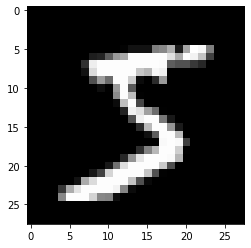

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch 使用的是 `torch.tensor` 而不是 numpy 数组，因此我们需要把数据转换一下

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.as_tensor,(x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 二、从头构建神经网络(不使用 `torch.nn`)

首先，我们只使用 PyTorch 张量操作来创建一个简单的线性模型。  
PyTorch 提供了随机或零填充创建张量的方法，我们将使用这些方法为这个模型创建权重 w 和偏差 b。  
这些只是普通的张量，还有一个非常特殊的点: 我们告诉 PyTorch 它们需要计算梯度。  
这使得 PyTorch 需要记录在张量上执行的所有操作，这样就可以在反向传播过程中自动计算梯度！

对于权重，我们在初始化之后设置 `require_grad`，因为我们不希望该步骤包含在梯度的计算中。注意：PyTorch 中的下划线 _ 表示该操作是行内执行的（结果改变原数据）  
> 注 我们在这里使用 [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 初始化权重(乘以 $\frac{1}{\sqrt{n}}$))。

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

多亏了 PyTorch 能够自动计算梯度，我们因此可以使用任何标准的 Python 函数(或可调用对象)作为模型！  
所以我们来写一个简单的矩阵乘法创造一个简单的线性模型。我们还需要一个激活函数，所以我们写一个 log_softmax 来用。  
请记住: 尽管 PyTorch 提供了许多预先编写的损失函数、激活函数等等，但我们可以很容易地使用 Python 编写自己的函数。PyTorch 甚至可以为你的函数自动创建快速 GPU 或向量化 CPU 代码。

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

在上面的例子中,@代表点积操作。我们将对一批数据(在本例中是64个图像)执行函数。这是一次向前传播。注意，此时我们的预测不会比随机预测更好，因为我们初始的权重是随机数。

In [7]:
bs = 64 # 一批数据的尺寸: batch size
xb = x_train[0:bs] # 来自 x 的一批数据
preds = model(xb)
print(preds[0], preds.shape)

tensor([-1.9393, -2.1730, -2.6403, -2.2938, -2.3437, -3.0033, -2.8421, -2.0438,
        -1.7122, -2.8783], grad_fn=<SelectBackward>) torch.Size([64, 10])


如你所见，`preds` 不仅包含张量的值，还包含一个梯度函数 `grad_fn`。我们以后会用这个来做支撑。  
接下来实现一个负对数似然函数作为损失函数（依旧可以使用 Python 代码手动实现）

In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

用我们的随机模型来检验一下 loss，这样就可以看看 loss 能否在后来的反向传播后得到改善。

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4275, grad_fn=<NegBackward>)


下面我们再实现一个计算模型准确性的函数。对于每一次预测，如果最大值与目标值匹配，那么这次预测就是正确的。

In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return  (preds == yb).float().mean()

检查一下随机模型的准确性，这样我们就可以看到准确性是否随着 loss 的改善而提高

In [11]:
print(accuracy(preds, yb))

tensor(0.0938)


现在可以运行一个训练循环，每一次迭代，我们将：  
 - 选择一小批数据（确定`bs`的大小）
 - 用模型进行预测
 - 计算 loss
 - `loss.backward()`计算模型的梯度，在这个例子中，计算的是`weights`和`bias`的梯度

我们通过计算梯度来更新权重和偏差，添加 `torch.no_grad()` 是因为我们不希望这些操作被记录下来用于下一次梯度的计算。你可以在[这里](https://pytorch.org/docs/stable/notes/autograd.html)了解 PyTorch 的 Autograd 是如何记录操作的。  

然后，我们将梯度设置为零，以便为下一个循环做好准备。否则，我们的梯度将记录所有操作的记录(例如 `loss.backward()` 将梯度添加到已经存储的内容中，而不是替换它们)。  

 > 注意：
  您可以使用标准 python 调试器单步执行 PyTorch 代码，你可以检查每一步的各种变量值。取消下面的 `set_trace()` 的注释试一下。

In [12]:
from IPython.core.debugger import set_trace

lr = 0.5  # 学习率
epochs = 2  # 训练的轮数

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
#         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

搞定：我们完整地创建并训练了一个最小的神经网络(逻辑回归模型，因为没有隐藏层) ！
让我们检查一下 loss 和准确度。与之前的结果进行比较，预计损失会减少，准确性会增加。（确实）

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0804, grad_fn=<NegBackward>) tensor(1.)


## 三、使用 torch.nn.functional  
现在我们来重构刚才的代码，做同样的事情，只是这次用的是 PyTorch 的 `nn` 类来使其更简洁、更灵活。  
在现在开始的每个步骤中，我们都尽量让代码变得更短、更容易理解也更灵活。  

第一步最简单，通过将手写的激活和损失函数替换为 `torch.nn.functional` 中的函数(约定俗成命名为 `F`)来缩短代码。  
这个模块包含` torch.nn` 库中的所有函数。除了广泛使用的损失函数和激活函数之外，你还可以在这里找到一些用于创建神经网络的函数，比如池化函数，还有一些函数用于处理卷积层、线性层等等。  

如果你使用负对数似然作为损失函数和 log softmax 作为激活函数，Pytorch 提供了一个专门的函数 `F.cross-entropy` 将两者结合了起来。所以我们可以从之前的模型中移除激活函数。

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

注意，我们不再在 `model` 里调用 `log_softmax()` ，我们看看 loss 和准确度是不是没变。

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0804, grad_fn=<NllLossBackward>) tensor(1.)


## 四、使用 `nn.Module` 进行重构  

下一步，我们将使用 `nn.Module` 和 `nn.Parameter` 来使训练过程更简明。我们把 `nn.Module` （其自身是一个可以追踪状态的类）子类化。  

在这个例子中，我们要创建一个类来保存权重和偏差，以及向前传播的方法。我们会用到许多 `nn.Module` 的属性和方法（比如 `.parameters()` 和 `.zero_grad()`）。  

 > 注意：  
  `nn.Model` （M 要大写）是一个 PyTorch 特有的概念，也是我们最常使用的一个类。  
  别把它和 Python 中的“模块” `module` 搞混了，后者是一个可以引入的代码文件。

In [16]:
from torch import nn

class Mnist_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

所以我们现在操作的是一个对象，而不仅仅是一个函数了。我们需要先实例化模型：

In [17]:
model = Mnist_logistic()

现在我们可以像往常一样计算 loss。注意 `nn.Module` 对象用起来跟函数一样（都可以调用），但是Pytorch会在后台自动调用 forward 方法。

In [18]:
print(loss_func(model(xb), yb))

tensor(2.3362, grad_fn=<NllLossBackward>)


在我们之前的训练中，我们要根据名字更新每个参数的值，然后手动把每个参数的梯度清零，像这样：
```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

现在我们可以利用 `model.parameters()` 和 `model.zero_grad()` （它们都是由 PyTorch 为 `nn.Module` 定义的）来使这些步骤更简洁，并且不容易出现忘记某些参数的错误，特别是当我们有一个更复杂的模型的时候:  
```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

把我们的小训练循环包装在一个 `fit` 函数中，这样后面可以再次运行它。

In [19]:
def fit():
    for epoch in range(epochs):
        for i in range((n -1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

我们再确认一下 loss 是不是降低了：

In [20]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0790, grad_fn=<NllLossBackward>)


## 五、使用 `nn.Linear` 重构  

我们继续重构代码。为了不再手动定义和初始化 `self.weights` 和 `self.bias`，不在手动计算 `xb @ self.weights + self.bias`，我们将使用 Pytorch 类 [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear-layers) 的线性层来实现。Pytorch 有许多类型的预定义层，这些层可以极大地简化我们的代码并且通常执行地更快。

In [21]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

我们实例化模型并用同样的方式计算 loss：

In [22]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2963, grad_fn=<NllLossBackward>)


我们依然可以使用之前同样地 `fit` 方法。

In [23]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0822, grad_fn=<NllLossBackward>)


## 六、使用 optim 重构  

Pytorch 还有一个包，包含各种优化算法，叫 `torch.optim`。我们可以使用优化器中的 `step` 方法而不必手动更新每个参数。  
这样我们就可以替换先前手动优化地步骤：
```python
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()
```

只需：
```python
opt.step()
opt.zero_grad()
```  

（`optim.zero_grad()` 将梯度重设为0，我们需要在计算下一个小批量的梯度之前调用它。）

In [24]:
from torch import optim

我们定义一个简单地函数来创建模型和优化器，以便将来重用。

In [25]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(2.3174, grad_fn=<NllLossBackward>)
tensor(0.0816, grad_fn=<NllLossBackward>)


## 七、使用 `Dataset` 重构  

PyTorch 有一个抽象的 `Dataset` 类。数据集可以是任何具有 `__len__` 函数(由 Python 的标准 `len` 函数调用)和 `__getitem__` 函数作为其索引方式的函数。  
本教程将介绍如何创建自定义 `FacialLandmarkDataset` 类作为 `Dataset` 子类。  

PyTorch 的 [`TensorDataset`](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset) 是一个包装数据集的张量。通过定义长度和索引方式为我们提供一种沿着张量的第一维进行迭代、索引和切片的方法。这使得我们在训练时更容易在一行内获取自变量和因变量。

In [26]:
from torch.utils.data import TensorDataset

可以将 `x_train` 和 `y_train` 拼在一个 `TensorDataset` 内，这样可以更容易地遍历和切片。

In [27]:
train_ds = TensorDataset(x_train, y_train)

以前，我们必须分别迭代小批量的 x 和 y 值:
```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```  

现在我们可以两步并一步:
```python
xb, yb = train_ds[i*bs: (i+1)*bs]
```

In [28]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i*bs: (i+1)*bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>)


## 八、使用 `DataLoader` 重构  
  
Pytorch 的 `DataLoader` 负责管理批处理。你可以从任何 `Dataset` 创建一个 `DataLoader`。  
`DataLoader` 使得在批处理上进行迭代更加容易。不必使用 `train_ds[i*bs: i*b+b]`，`DataLoader` 会自动拆分小批量的数据。

In [29]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

在此之前，我们的循环遍历批处理(xb，yb)如下所示:  
```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```  

现在，我们的循环更加简洁，因为(xb，yb)是从数据加载器自动加载的：
```python
for xb, yb in train_dl:
    pred = model(xb)
```

In [30]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward>)


多亏了 Pytorch 的`nn.Module`，`nn.Parameter`、`Dataset` 和 `DataLoader`，我们的训练循环现在明显变小了，而且更容易理解。  
现在，让我们尝试添加作为一个有效的模型所必需的基本特性。

## 九、添加验证（集）

在第1节中，我们只是在训练集上训练模型。实际上，你总得有一个[验证集](https://www.fast.ai/2017/11/13/validation-sets/)，来判断模型是否过拟合。  

重新排列训练集的数据对于防止批次之间的相关性和过拟合[非常重要](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks)。另一方面，无论是否对验证集进行打乱，验证集的 loss 都是相同的。而打乱数据需要额外的时间，所以打乱**验证集**是没有意义的。  

我们设定验证集的批大小是训练集批大小的两倍。这是因为验证集不需要反向传播，因此占用的内存更少(不需要存储梯度)。因此使用更大批量,且计算 loss 更快。

In [31]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

我们会在每次遍历结束时计算和打印验证集损失。  

(注意，我们总是在训练之前调用 `model.train()` ，在预测之前调用 `model.eval()`，因为它们会些被 `nn.BatchNorm2d ` 和 `nn.Dropout` 这些层用来确保在不同阶段被正确执行)

In [32]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3084)
1 tensor(0.2896)


## 十、创建 `fit()` 和 `get_data()`  

由于我们经历了两次类似的过程——计算训练集和验证集的损失，让我们把它重构为 `loss _ batch`，计算一次批处理的损失。  

我们给训练集传入一个优化器来运算向后传播。对于验证集，我们不需要向后传播,所以也不需要优化器。

In [33]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

`fit` 用来运行必要的操作来训练我们的模型并计算每批的训练和验证损失。

In [34]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
            *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

`get_data` 返回训练集和验证集的数据加载器。

In [35]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

至此,我们获取数据加载器和拟合模型的过程可以用3行代码完成:

In [36]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3120915981769562
1 0.2923691803574562


你可以使用这 3 行代码来训练各种各样的模型。让我们看看能否用它们来训练一个卷积神经网络！

## 十一、切换到卷积神经网络  

我们要用三个卷积层构建一个神经网络。因为前一节中的函数都没有关于模型形式的内容，所以我们不用任何修改就可以训练 CNN。  

我们将使用 Pytorch 预定义的 [Conv2d]https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d() 类作为卷积层。我们定义一个具有 3 个卷积层的 CNN。每个卷积后面跟一个 ReLU，最后再进行一次平均池化。(注意，`view` 是 PyTorch 版本的 numpy `reshape`)

In [37]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

[动量](https://cs231n.github.io/neural-networks-3/#sgd)是随机梯度下降的一个变种，它把以前的梯度更新也考虑在内，一般会使训练加快。

In [38]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.5321439875125885
1 0.26564762756824495


## 十二、`nn.Sequential`  

`torch.nn` 还有一个方便的类——[`Sequential`](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential)我们可以用它来简化代码。一个 `Sequential` 对象按顺序运行其中包含的每个模块。  

为了利用这一点，我们需要能够轻松地从给定的函数定义一个自定义层。例如，PyTorch 没有 `view` 层，我们需要为网络创建一个。`Lambda`将创建一个可以使用 `Sequential` 定义网络的层。

In [39]:
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

用 `Sequential` 创建模型很简单：

In [40]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34674787967205045
1 0.23097456965446472


## 十三、封装 DataLoader  

虽然我们的 CNN 已经很简洁了，但只能工作在 MNIST 上，这是因为：  
- 它假设的输入是 28*28 的向量  
- 它假设最终的 CNN 的网格大小为4 * 4  

让我们去掉这两个假设，这样我们的模型可以适用于任何二维单通道图像。  
首先，我们可以移除初始的 Lambda 层，转而将数据预处理移动到一个生成器中：

In [41]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

接下来，我们可以用 ` nn.AdaptiveAvgPool2d` 替换 `nn.AvgPool2d`，它允许我们定义想要的输出张量的大小。因此，我们的模型将适用于任何大小的输入。

In [42]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4273653765201569
1 0.23021787621974946


## 十四、使用 GPU  

如果你有支持 CUDA 的 GPU，那么可以用 GPU 来加速代码的执行，首先检查一下你的 GPU 支不支持 PyTorch：

In [43]:
print(torch.cuda.is_available())

True


然后创建一个设备对象:

In [44]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

我们更新一下 `preprocess` 把批处理转移到 GPU 上：

In [45]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

最后,我们把模型也转移到 GPU 上：

In [46]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

你会发现速度变快了：

In [47]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.19471970977187156
1 0.17603057650327683


## 十五、总结  

我们现在有了一个通用数据管道和训练循环，你可以使用 PyTorch 来训练各种模型了。  

当然，还有很多东西需要添加，比如数据增强、超参数优化、监控训练、迁移学习等等。这些特性可以在 fastai 库中获取，该库是使用本教程中展示的相同设计方法开发的，为希望进拓展他们的模型的从业者提供了更进一步的帮助。  

在本教程的开始，我们承诺将通过示例解释 `torch.nn`、 `torch.optim`、 `Dataset` 和 `DataLoader`。那么让我们看看都学到了什么：
- torch.nn  
    - `Module`:创建一个像函数一样的可调用，但是也可以包含状态(比如神经网络层权重)的对象。它知道它包含哪些`Parameter`，可以将所有的梯度归零，循环遍历参数以进行权重更新等等。  
    - `Parameter`:对张量的封装，用来告知一个 `Module` 在反向传播期间需要更新的权重。只有 `requires_grad()=True`的张量才会被更新。  
    - `functional`:一个包含激活函数、损失函数等，以及一些无状态的层（如卷积层和线性层）的模块，导入时一般命名为 F。  
- `torch.optim`:包含诸如 `SGD` 之类的优化器，这些优化器在反向传播期间更新 `Parameter` 的权重。  
- `Dataset`:具有 `__len__` 和 `__getitem__` 的对象的抽象接口，包括像 `TensorDataset` 这种 Pytorch 提供的类。  
- `DataLoader`:获取任意 `Dataset` 并创建一个返回批数据的迭代器。